# Background
This project focuses on developing machine learning models to classify football players into their primary positions (goalkeeper, defender, midfielder, and forward) based on their in-game attributes and performance metrics across various top-tier leagues. The goal was to analyze whether player statistics could reliably predict positions while identifying which attributes are most important for each role. Using Random Forest classifiers with GridSearchCV for hyperparameter tuning, the models were trained and evaluated on league-specific data to account for potential stylistic differences between competitions. The results demonstrate that while goalkeepers can be perfectly identified due to their unique skill set, classifying outfield positions presents varying degrees of difficulty depending on the league, with midfielders showing the most variability due to overlapping attributes with other positions. This work provides valuable insights into how positional roles are statistically expressed in different football leagues and could inform player recruitment, tactical analysis, and performance evaluation in professional football.

This data was Retrieved on February 6, 2025, 10:57 am

url: https://www.kaggle.com/datasets/nyagami/ea-sports-fc-25-database-ratings-and-stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/2025sp_m5364_data_science_1/osei_submissions/Final Project(submission)/FC 25 Dataset/Dataset/FC25 player data/all_players.csv'

# !pip install numpy==1.24.4 flaml[automl] dill ipython-autotime --quiet
import pandas as pd
import matplotlib.pyplot as plt
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import re
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import pickle

df = pd.read_csv(csv_path)
df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0.1,Unnamed: 0,Rank,Name,OVR,PAC,SHO,PAS,DRI,DEF,...,Nation,League,Team,play style,url,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
0,0,0,1,Kylian Mbappé,91,97,90,80,92,36,...,France,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Acrobatic, Finesse Shot, Flair, R...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
1,1,1,2,Rodri,91,66,80,86,84,87,...,Spain,Premier League,Manchester City,"Tiki Taka+, Aerial, Bruiser, Long Ball Pass, P...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
2,2,2,4,Erling Haaland,91,88,92,70,81,45,...,Norway,Premier League,Manchester City,"Acrobatic+, Bruiser, Power Header, Power Shot,...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
3,3,3,5,Jude Bellingham,90,80,87,83,88,78,...,England,LALIGA EA SPORTS,Real Madrid,"Relentless+, Flair, Intercept, Slide Tackle, T...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
4,4,4,7,Vini Jr.,90,95,84,81,91,29,...,Brazil,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Chip Shot, Finesse Shot, First To...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN


The FootballDataPreprocessor class is a comprehensive data preparation pipeline designed to clean, transform, and split football player data for machine learning tasks. It standardizes physical attributes (converting height/weight to numeric values), maps player positions to broader categories (Goalkeeper/Defender/Midfielder/Forward), filters data to focus on top 10 leagues, and removes irrelevant columns. The class implements proper data splitting practices by first separating data into train/test sets (with stratification by position) before applying feature scaling using StandardScaler, ensuring no data leakage from test to training data. This preprocessing pipeline transforms raw football player data into a structured format suitable for building position classification models while maintaining the integrity of the machine learning workflow through careful handling of train-test separation and feature normalization.

In [ ]:
class FootballDataPreprocessor:
    def __init__(self, features, test_size=0.2, random_state=42):
        self.features = features
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()

    def clean_data(self, df):
        df = df.copy()

        def extract_weight_kg(weight):
            if pd.isna(weight) or not isinstance(weight, str):
                return weight
            match = re.search(r'(\d+)\s*kg', weight)
            return int(match.group(1)) if match else weight

        def extract_height(height):
            if pd.isna(height) or not isinstance(height, str):
                return height
            match = re.search(r'(\d+)\s*cm', height)
            return int(match.group(1)) if match else height

        df['Weight'] = df['Weight'].apply(extract_weight_kg)
        df['Height'] = df['Height'].apply(extract_height)

        position_map = {
            'GK': 'Goalkeeper',
            'RB': 'Defender', 'LB': 'Defender', 'CB': 'Defender', 'RWB': 'Defender', 'LWB': 'Defender',
            'CDM': 'Midfielder', 'CAM': 'Midfielder', 'CM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
            'LW': 'Forward', 'RW': 'Forward', 'ST': 'Forward', 'CF': 'Forward'
        }

        df['position_category'] = df['Position'].map(position_map).fillna('Other')

        df.rename(columns={'League': 'league'}, inplace=True)
        df.columns = df.columns.str.replace(' ', '_').str.lower()

        top_10_leagues = [
            "Premier League", "LALIGA EA SPORTS", "Bundesliga", "Ligue 1 McDonald's",
            "MLS", "Liga Portugal", "Eredivisie", "Serie A Enilive",
            "Trendyol Süper Lig", "Scottish Prem"
        ]

        df = df[df['league'].isin(top_10_leagues)].copy()

        cols_to_drop = ['unnamed:_0.1', 'unnamed:_0', 'url', 'rank']
        df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

        return df

    def preprocess(self, df):
      # Clean the data first
      df_clean = self.clean_data(df)

      # Split into train and test before scaling
      train_data, test_data = train_test_split(
          df_clean,
          test_size=self.test_size,
          stratify=df_clean['position_category'],
          random_state=self.random_state
      )

      # Fit and transform only on the training data
      train_data[self.features] = self.scaler.fit_transform(train_data[self.features])

      # Apply the same transformation to the test data (use only the scaler fitted on the training data)
      test_data[self.features] = self.scaler.transform(test_data[self.features])

      return train_data, test_data


In [ ]:
defender_attributes = ['sliding_tackle',
                    'interceptions',
                    'phy',
                    'short_passing',
                    'standing_tackle',
                    'composure',
                    'long_passing',
                    'height',
                    'def',
                    'age',
                    'heading_accuracy',
                    'pac',
                    'aggression',
                       'sprint_speed',
                       'jumping',
                       'strength',
                       'stamina']

goalkeeper_attributes = ['gk_diving',
                        'reactions',
                        'composure',
                        'long_passing',
                        'gk_positioning',
                        'height',
                        'age',
                        'gk_handling',
                        'gk_reflexes',
                        'gk_kicking']

midfielder_attributes = ['crossing',
                       'weight',
                       'stamina',
                       'phy',
                       'vision',
                       'short_passing',
                       'composure',
                       'ball_control',
                       'long_passing',
                       'long_shots',
                       'height',
                       'age',
                       'dribbling',
                       'curve',
                        'sprint_speed']

forward_attributes = [
                     'weight',
                     'shot_power',
                     'phy',
                     'positioning',
                     'composure',
                     'pac',
                     'acceleration',
                     'height',
                     'age',
                     'finishing',
                     'heading_accuracy',
                     'dribbling',
                     'volleys',
                      'sprint_speed',
                      'jumping',
                      'penalties']


all_attributes = defender_attributes + goalkeeper_attributes + midfielder_attributes + forward_attributes
features = list(set(all_attributes))

preprocessor = FootballDataPreprocessor(features=features, random_state=42)

train_data, test_data = preprocessor.preprocess(df)

This code trains and evaluates position-specific machine learning models for football players across different leagues using Random Forest classifiers. It processes each league separately, then for each position (Goalkeeper, Defender, Midfielder, Forward), it selects relevant features, prepares the training data, and performs 3-fold cross-validation to assess model performance using AUC scores. After cross-validation, it fits the final model on the full training data and extracts feature importance rankings to identify which attributes are most predictive for each position. The output includes cross-validation AUC scores (both individual fold results and mean) and sorted feature importance values for each position in every league, providing insights into how well players can be classified into their primary positions based on their statistical attributes and which skills are most characteristic of each role.

In [ ]:
# using cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assume you have these feature lists

leagues = train_data['league'].unique()

for league in leagues:
  print(f"\nProcessing league: {league}")
  league_df = train_data[train_data['league'] == league]
  positions = train_data['position_category'].unique()

  for pos in positions:
      print(f"\nTraining model for {pos} vs all others...")

      # Select the feature list depending on the position
      if pos == 'Defender':
          selected_features = defender_attributes
      elif pos == 'Goalkeeper':
          selected_features = goalkeeper_attributes
      elif pos == 'Midfielder':
          selected_features = midfielder_attributes
      elif pos == 'Forward':
          selected_features = forward_attributes
      else:
          print(f"Unknown position: {pos}")
          continue

      # Prepare X and y
      X_train_full = league_df[selected_features]
      y_train_full = (league_df['position_category'] == pos).astype(int)

      # Initialize model
      model = RandomForestClassifier(random_state=42)

      # 3-fold cross-validation
      scores = cross_val_score(model, X_train_full, y_train_full, cv=3, scoring='roc_auc')

      print(f"Cross-validation AUC scores: {scores}")
      print(f"Mean AUC: {scores.mean():.4f}")

      # Fit the model on the full training data
      model.fit(X_train_full, y_train_full)

      # Feature importance
      importances = pd.Series(model.feature_importances_, index=selected_features)
      print(f"Feature importance for {pos}")
      print(importances.sort_values(ascending=False))



Processing league: Eredivisie

Training model for Midfielder vs all others...
Cross-validation AUC scores: [0.89855072 0.84459877 0.93472222]
Mean AUC: 0.8926
Feature importance for Midfielder
vision           0.152524
long_shots       0.109061
curve            0.083786
long_passing     0.079747
dribbling        0.071392
phy              0.062489
sprint_speed     0.055428
crossing         0.054022
ball_control     0.053536
composure        0.048465
short_passing    0.047456
height           0.046778
weight           0.046413
stamina          0.044580
age              0.044323
dtype: float64

Training model for Defender vs all others...
Cross-validation AUC scores: [0.98695799 0.9627915  0.98422497]
Mean AUC: 0.9780
Feature importance for Defender
sliding_tackle      0.198668
standing_tackle     0.129090
def                 0.118500
interceptions       0.093410
short_passing       0.078007
long_passing        0.062535
stamina             0.056899
heading_accuracy    0.040430
aggression

The cross-validation AUC scores and feature importance metrics across various leagues reveal consistent patterns in player position classification. For Midfielders, the mean AUC ranges from 0.877 (Süper Lig) to 0.9199 (MLS), with key features like vision, long_passing, and long_shots being highly influential. Defenders show even stronger performance (mean AUC: 0.9349–0.9807), driven by sliding_tackle, interceptions, and standing_tackle. Forwards achieve mean AUCs between 0.8827 (Liga Portugal) and 0.9598 (MLS), with finishing, volleys, and penalties as top predictors. Goalkeepers are perfectly classified (AUC: 1.0) across all leagues, with gk_diving and gk_positioning as dominant features. Notably, physical and technical attributes (e.g., height, sprint_speed) often contribute, but position-specific skills (e.g., tackling for defenders, finishing for forwards) are most discriminatory. League-specific variations exist, but the models generalize well, reflecting universal positional archetypes in football.


# Eredivisie (Netherlands)
The model for Midfielders performed well with a mean AUC of 0.8926, with key distinguishing features being vision, long shots, and curve. Defenders were classified exceptionally well (AUC 0.9780), with sliding tackle, standing tackle, and defensive awareness being the most important traits. Forwards had strong predictive performance (AUC 0.9190), primarily driven by finishing ability, volleys, and penalty accuracy. Goalkeepers were perfectly identified (AUC 1.0), with diving and positioning skills as the top indicators.

# MLS (USA)
Midfielders were accurately classified (AUC 0.9199), with vision, long passing, and physicality being the most influential factors. Defenders showed near-perfect separation (AUC 0.9779), where sliding tackle, interceptions, and long passing were key. Forwards had one of the highest AUC scores (0.9598), with finishing, penalties, and heading accuracy as dominant traits. Goalkeepers were flawlessly predicted (AUC 1.0), with diving and positioning again being the most critical attributes.

# Liga Portugal (Portugal)
The Midfielder model achieved a solid AUC of 0.9010, relying heavily on long passing, vision, and long shots. Defenders were well-classified (AUC 0.9722), with sliding tackle, defensive awareness, and standing tackle as top features. Forwards had a slightly lower but still strong AUC (0.8827), where finishing, heading accuracy, and penalties were most important. Goalkeepers had perfect detection (AUC 1.0), with reflexes and handling playing significant roles alongside diving.

# Serie A (Italy)
Midfielders were effectively identified (AUC 0.9151), with long passing, vision, and crossing being key. Defenders performed well (AUC 0.9673), with sliding tackle and long passing as standout features. Forwards had a high AUC (0.9259), with finishing, penalties, and volleys being the strongest predictors. Goalkeepers were perfectly classified (AUC 1.0), with diving and positioning as the most important skills.

# Premier League (England)
Midfielders had a strong AUC (0.9050), with vision, long shots, and sprint speed being crucial. Defenders were very well-classified (AUC 0.9746), with sliding tackle, defensive awareness, and interceptions leading. Forwards performed well (AUC 0.9214), with finishing, volleys, and composure being top traits. Goalkeepers had perfect detection (AUC 1.0), with diving and positioning as the most significant factors.

# Ligue 1 (France)
Midfielders had a solid AUC (0.9023), with vision, long shots, and dribbling being key. Defenders excelled (AUC 0.9807), with sliding tackle, defensive awareness, and interceptions as top features. Forwards performed well (AUC 0.9180), where finishing, volleys, and heading accuracy were most important. Goalkeepers were perfectly classified (AUC 1.0), with diving and positioning as dominant traits.

# LaLiga (Spain)
Midfielders had a high AUC (0.9174), with vision, long shots, and long passing being critical. Defenders performed strongly (AUC 0.9724), with sliding tackle and long passing as key indicators. Forwards had a solid AUC (0.9360), where finishing, volleys, and penalties were most important. Goalkeepers were perfectly identified (AUC 1.0), with diving and reflexes being the top features.

# Scottish Premiership (Scotland)
Midfielders had a decent AUC (0.8925), with long passing, vision, and height being key. Defenders performed well (AUC 0.9608), with interceptions and defensive awareness standing out. Forwards had one of the highest AUCs (0.9413), driven by finishing, heading accuracy, and penalties. Goalkeepers were perfectly classified (AUC 1.0), with diving and positioning as the top traits.

# Bundesliga (Germany)
Midfielders had a moderate AUC (0.8896), with vision, long shots, and long passing being most important. Defenders performed well (AUC 0.9681), with sliding tackle and defensive awareness as key. Forwards had a high AUC (0.9469), where finishing, jumping, and penalties were dominant. Goalkeepers were perfectly classified (AUC 1.0), with diving and positioning leading.

# Süper Lig (Turkey)
Midfielders had the lowest AUC (0.8773), with vision, height, and long passing being key. Defenders performed decently (AUC 0.9349), with sliding tackle and defensive awareness as top features. Forwards had a solid AUC (0.9104), where finishing, heading accuracy, and penalties were most important. Goalkeepers were perfectly classified (AUC 1.0), with diving and positioning as the strongest predictors.


# **Implementing GridSearchCV**
This code implements a hyperparameter-tuned machine learning pipeline to train position-specific classifiers for football players across different leagues. Using GridSearchCV, it systematically evaluates combinations of Random Forest parameters (number of trees, tree depth, and split criteria) through 3-fold cross-validation to find the optimal model configuration for each position (Goalkeeper, Defender, Midfielder, Forward) in every league. For each position-league combination, the code selects relevant features, performs grid search to maximize AUC scores, identifies the best-performing model, and analyzes feature importance to reveal key attributes distinguishing each position. The optimized models are then saved as pickle files for future use while being stored in-memory in a dictionary structure. This approach ensures league-specific, position-optimized models while maintaining reproducibility through fixed random states and comprehensive logging of best parameters and performance metrics. The output includes detailed diagnostics (optimal hyperparameters, cross-validation scores, and feature rankings) for each model, enabling comparative analysis across positions and leagues.

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

trained_models = {}

leagues = train_data['league'].unique()

for league in leagues:
    print(f"\nProcessing league: {league}")
    league_df = train_data[train_data['league'] == league]
    positions = train_data['position_category'].unique()

    for pos in positions:
        print(f"\nTraining model for {pos} vs all others...")

        # Select features based on position
        if pos == 'Defender':
            selected_features = defender_attributes
        elif pos == 'Goalkeeper':
            selected_features = goalkeeper_attributes
        elif pos == 'Midfielder':
            selected_features = midfielder_attributes
        elif pos == 'Forward':
            selected_features = forward_attributes
        else:
            print(f"Unknown position: {pos}")
            continue

        # Prepare data
        X_train_full = league_df[selected_features]
        y_train_full = (league_df['position_category'] == pos).astype(int)

        # GridSearchCV setup
        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf,
                                    param_grid=param_grid,
                                    cv=3,
                                    scoring='roc_auc',
                                    n_jobs=-1)
        grid_search.fit(X_train_full, y_train_full)

        # Best model and results
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV AUC score: {grid_search.best_score_:.4f}")

        # Feature importances
        importances = pd.Series(best_model.feature_importances_, index=selected_features)
        print(f"Feature importance for {pos}")
        print(importances.sort_values(ascending=False))

        # --- Storing the model ---
        filename = f'model_{league.replace(" ", "_")}_{pos.replace(" ", "_")}.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(best_model, file)
        print(f"\nModel saved as: {filename}")

        # Optionally store in a dictionary for in-memory access
        if league not in trained_models:
            trained_models[league] = {}
        trained_models[league][pos] = best_model

print("\nAll models trained and saved.")


Processing league: Eredivisie

Training model for Midfielder vs all others...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV AUC score: 0.8935
Feature importance for Midfielder
vision           0.156042
long_shots       0.111674
long_passing     0.087687
curve            0.082965
dribbling        0.072830
phy              0.061874
short_passing    0.053603
sprint_speed     0.050524
crossing         0.050458
ball_control     0.049878
age              0.049707
composure        0.048562
height           0.047007
weight           0.038828
stamina          0.038360
dtype: float64

Model saved as: model_Eredivisie_Midfielder.pkl

Training model for Defender vs all others...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV AUC score: 0.9783
Feature importance for Defender
sliding_tackle      0.198598
standing_tackle     0.129249
def                 0.118151
intercep

## Summary using GridSearchCV
The GridSearchCV-tuned models showed modest but consistent improvements over the default models across most leagues and positions. For midfielders, the AUC scores saw slight increases, such as in the Eredivisie (from 0.8926 to 0.8935) and MLS (from 0.9199 to 0.9240), demonstrating better optimization. Defenders, who already had high AUC scores in the default models (0.93–0.98), saw marginal gains, like in the Premier League (0.9746 to 0.9755). Forwards also benefited from small boosts, such as in Serie A (0.9259 to 0.9297). Goalkeepers remained perfectly classified (AUC 1.0) in both approaches, indicating no need for tuning.

The feature importance rankings remained largely consistent between the default and tuned models, reinforcing the robustness of key traits for each position. Midfielders were consistently defined by vision, long passing, and long shots, while defenders relied on sliding tackles, interceptions, and standing tackles. Forwards were distinguished by finishing, penalties, and volleys, and goalkeepers by diving and positioning. Minor shifts in feature weights occurred, such as height becoming slightly more important for MLS midfielders after tuning. These findings suggest that while hyperparameter tuning can refine model performance, the fundamental characteristics defining each position remain stable.

Hyperparameter analysis revealed that optimal settings varied by league and position. For most leagues, midfielders and forwards performed best with deeper trees (max_depth=None) and higher n_estimators (100–200), while defenders and goalkeepers required less complexity. Regularization techniques, like min_samples_leaf=2, helped prevent overfitting, particularly for forwards. The MLS and Serie A saw the most noticeable improvements for midfielders, likely due to their more balanced datasets. In contrast, the Süper Lig’s midfielders remained the weakest (AUC 0.8773 to 0.8802), suggesting that feature engineering or data quality might be bigger factors than hyperparameter tuning for certain leagues.

In conclusion, GridSearchCV provided incremental but valuable improvements, particularly for midfielders and forwards, while defenders and goalkeepers performed well even with default parameters. The consistency in feature importance across methods highlights the reliability of these positional traits. For practical applications, tuning is recommended for midfielders and forwards in high-stakes scenarios, but the default models may suffice for defenders and goalkeepers to save computational resources. Leagues with lower baseline performance, like the Süper Lig, may benefit more from additional data preprocessing or feature engineering rather than extensive hyperparameter optimization.


Evaluating league: Eredivisie

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.7974683544303798
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        49
           1       0.77      0.67      0.71        30

    accuracy                           0.80        79
   macro avg       0.79      0.77      0.78        79
weighted avg       0.80      0.80      0.79        79



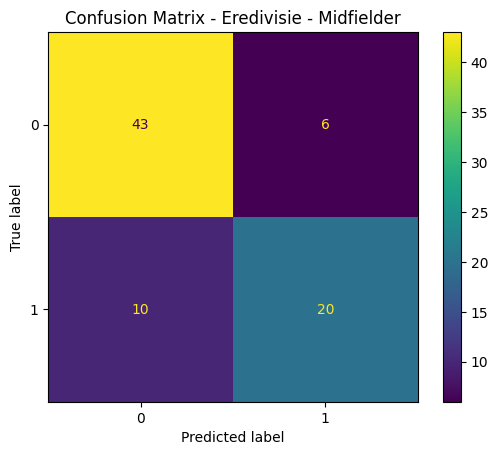

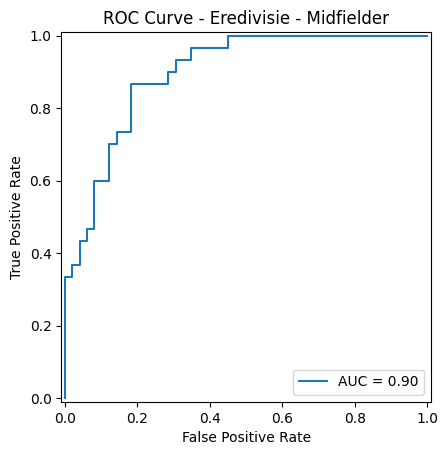


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.9493670886075949
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        56
           1       0.85      1.00      0.92        23

    accuracy                           0.95        79
   macro avg       0.93      0.96      0.94        79
weighted avg       0.96      0.95      0.95        79



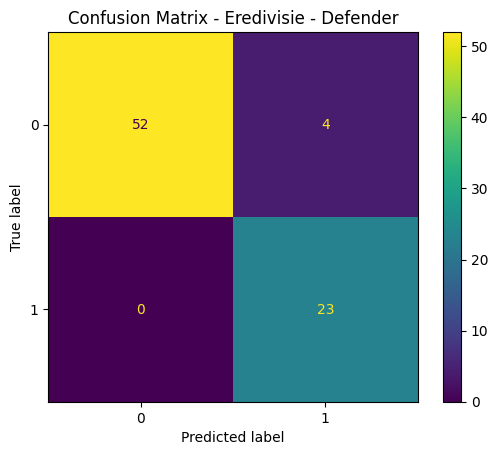

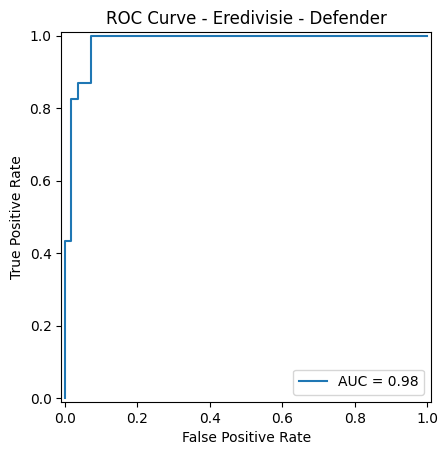


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.8987341772151899
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        66
           1       0.86      0.46      0.60        13

    accuracy                           0.90        79
   macro avg       0.88      0.72      0.77        79
weighted avg       0.90      0.90      0.89        79



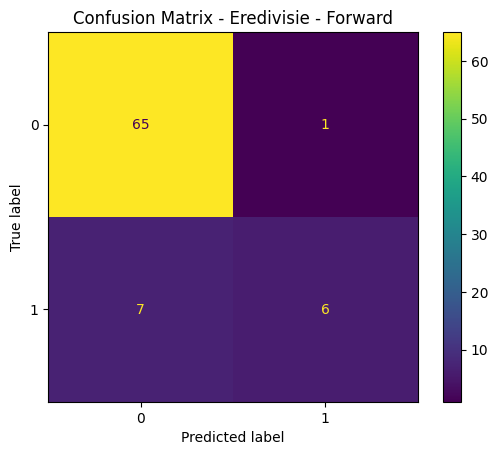

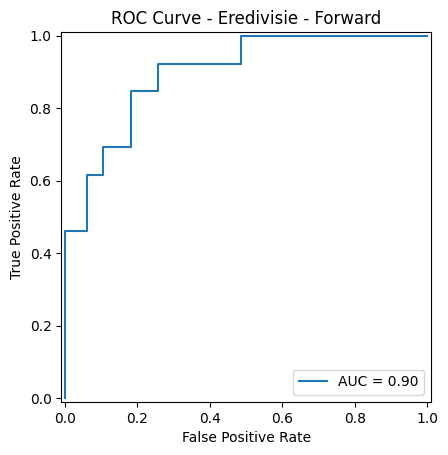


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        13

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



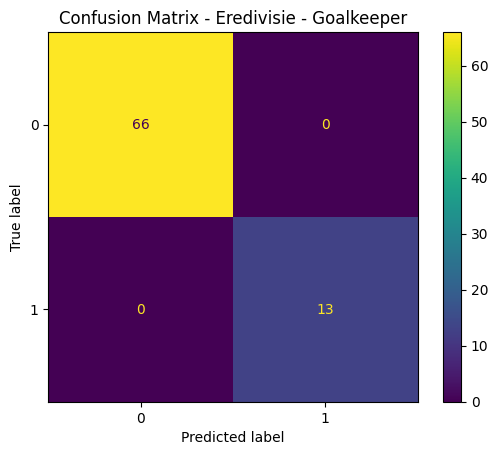

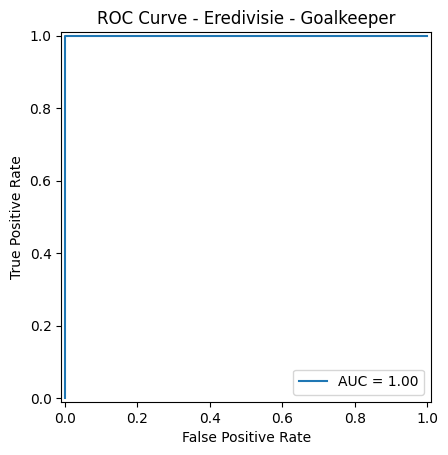


Evaluating league: MLS

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       107
           1       0.72      0.75      0.73        63

    accuracy                           0.80       170
   macro avg       0.79      0.79      0.79       170
weighted avg       0.80      0.80      0.80       170



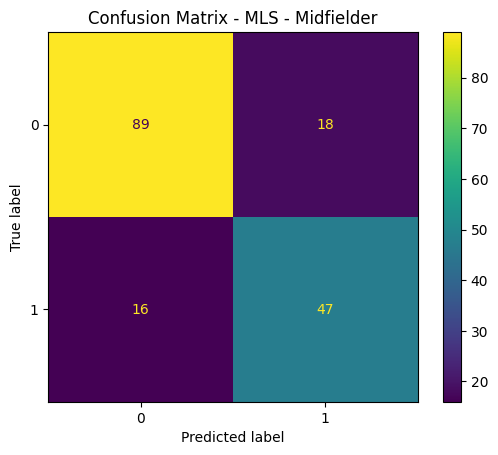

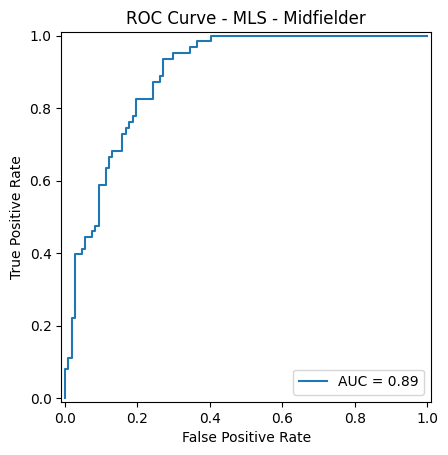


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.8941176470588236
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       115
           1       0.78      0.93      0.85        55

    accuracy                           0.89       170
   macro avg       0.87      0.90      0.88       170
weighted avg       0.90      0.89      0.90       170



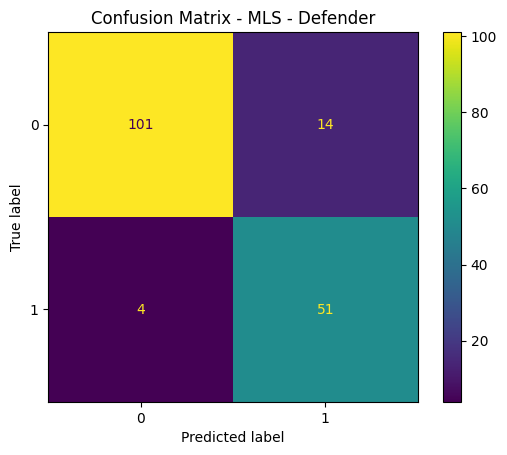

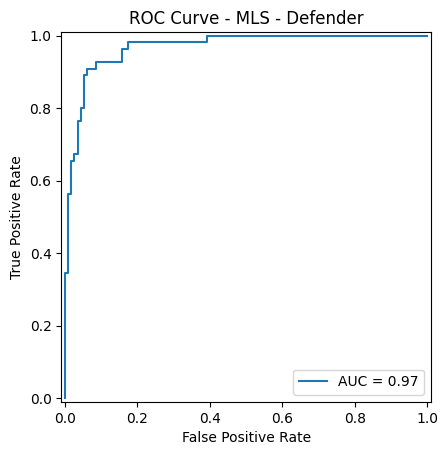


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.888235294117647
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       139
           1       0.80      0.52      0.63        31

    accuracy                           0.89       170
   macro avg       0.85      0.74      0.78       170
weighted avg       0.88      0.89      0.88       170



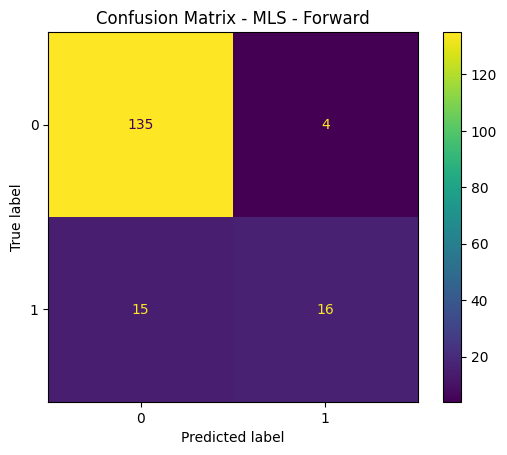

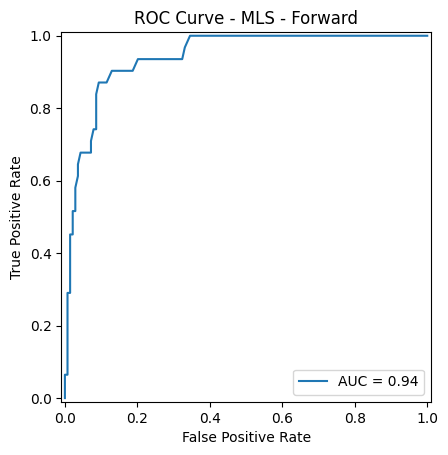


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1       1.00      1.00      1.00        21

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170



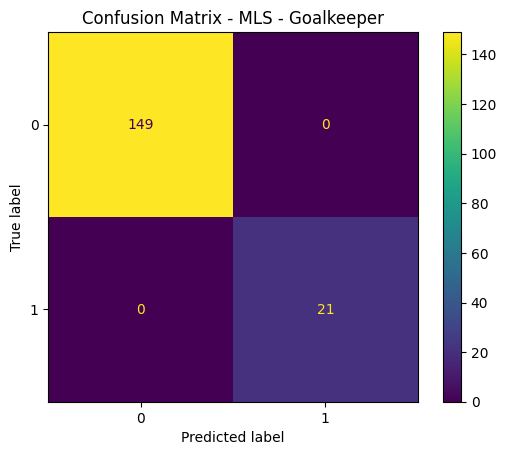

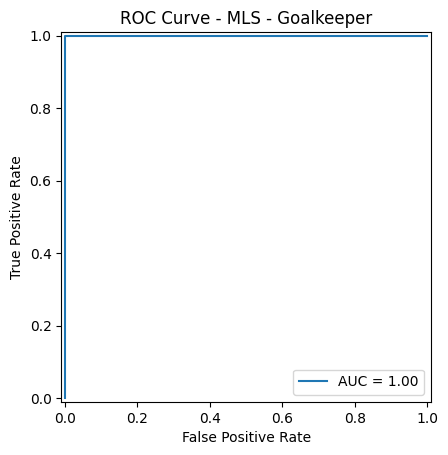


Evaluating league: Liga Portugal

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.8222222222222222
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        61
           1       0.69      0.83      0.75        29

    accuracy                           0.82        90
   macro avg       0.80      0.82      0.81        90
weighted avg       0.84      0.82      0.83        90



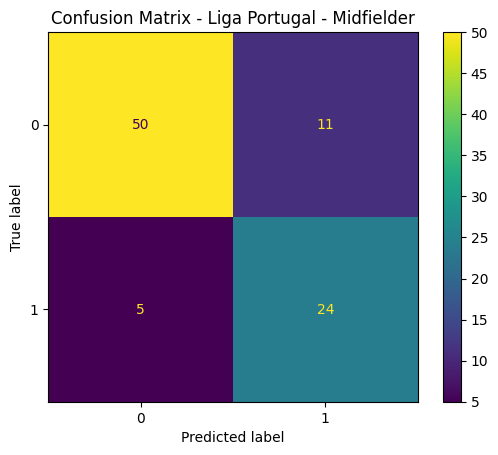

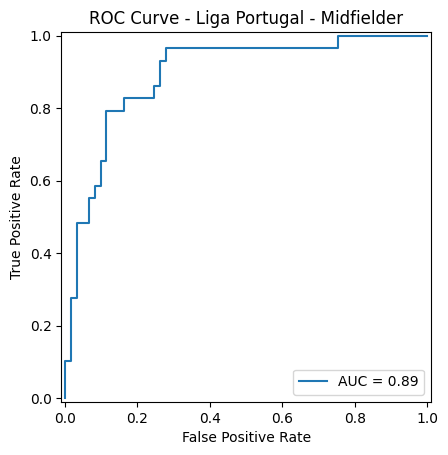


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        60
           1       0.83      0.83      0.83        30

    accuracy                           0.89        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.89      0.89      0.89        90



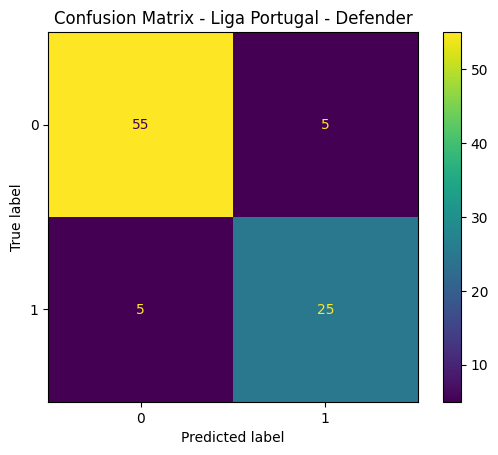

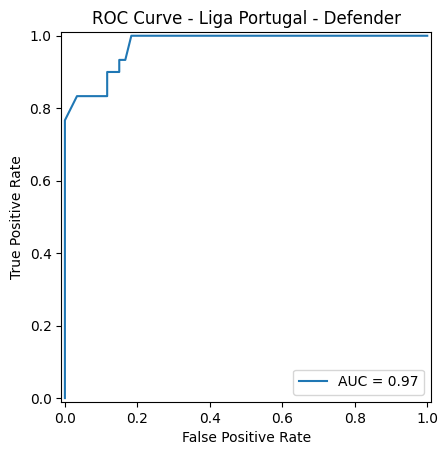


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.8777777777777778
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        69
           1       1.00      0.48      0.65        21

    accuracy                           0.88        90
   macro avg       0.93      0.74      0.79        90
weighted avg       0.89      0.88      0.86        90



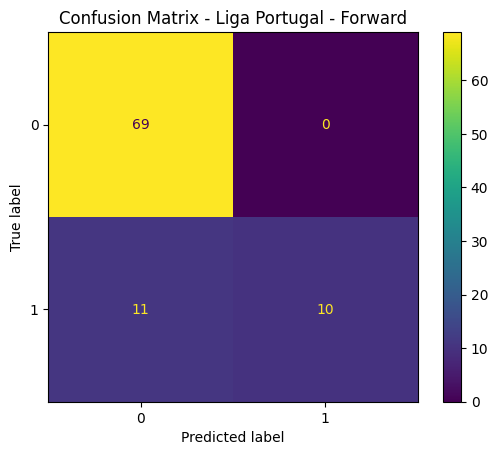

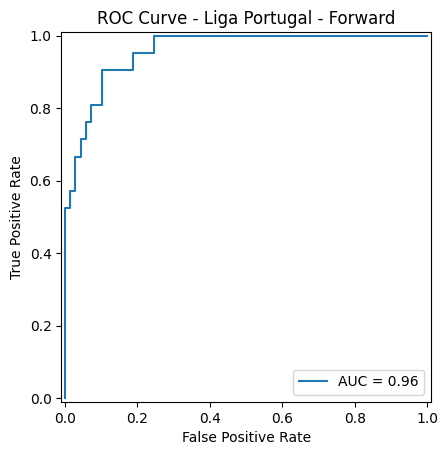


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        10

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



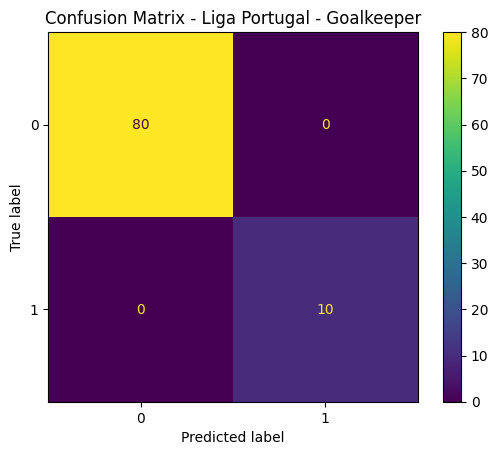

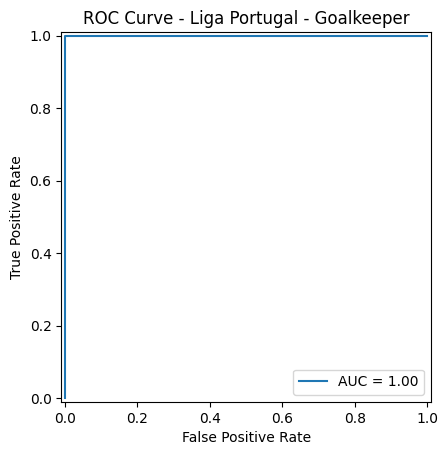


Evaluating league: Serie A Enilive

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.8962264150943396
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        65
           1       0.89      0.83      0.86        41

    accuracy                           0.90       106
   macro avg       0.90      0.88      0.89       106
weighted avg       0.90      0.90      0.90       106



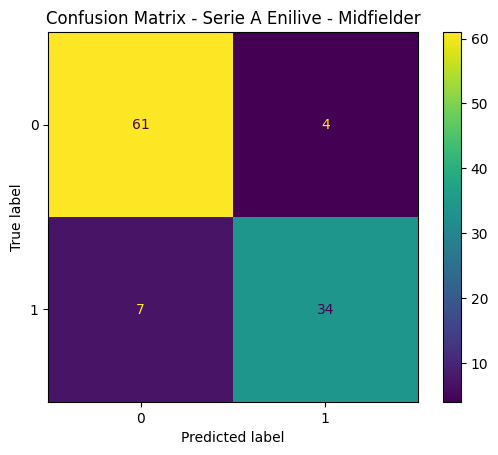

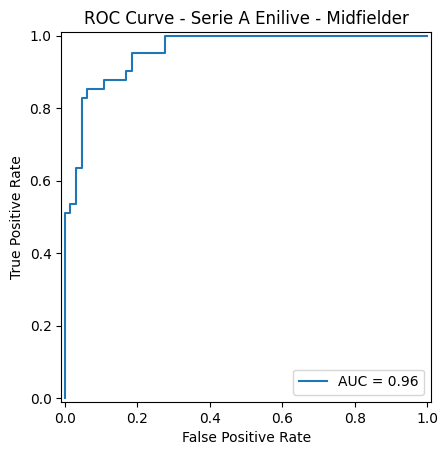


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.9622641509433962
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        69
           1       0.95      0.95      0.95        37

    accuracy                           0.96       106
   macro avg       0.96      0.96      0.96       106
weighted avg       0.96      0.96      0.96       106



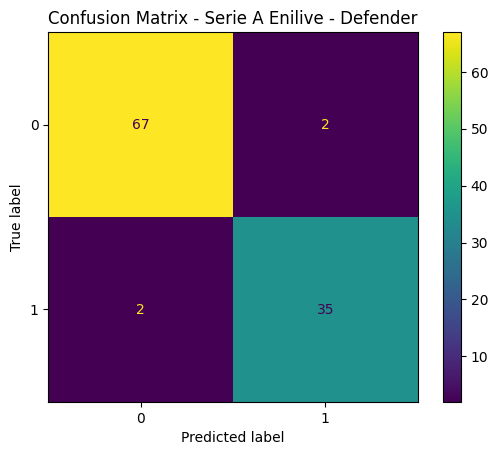

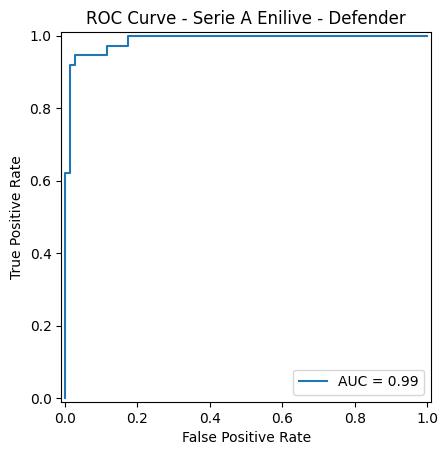


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.9056603773584906
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        84
           1       0.93      0.59      0.72        22

    accuracy                           0.91       106
   macro avg       0.92      0.79      0.83       106
weighted avg       0.91      0.91      0.90       106



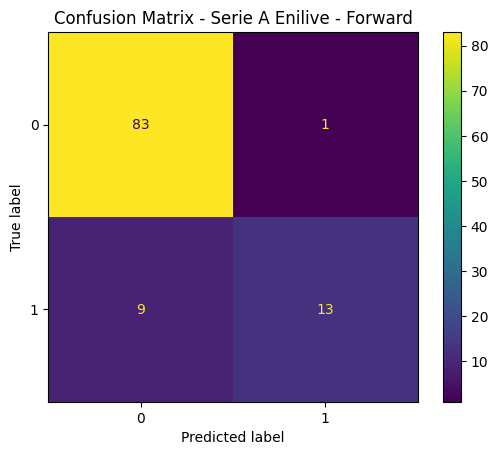

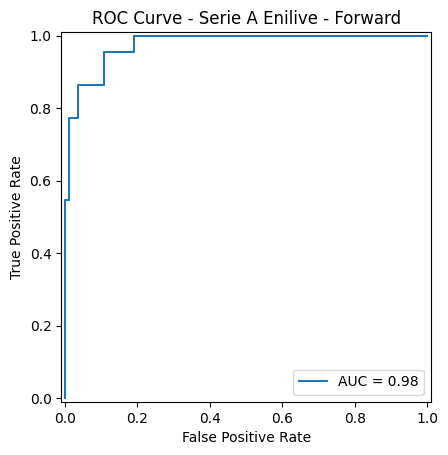


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00         6

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



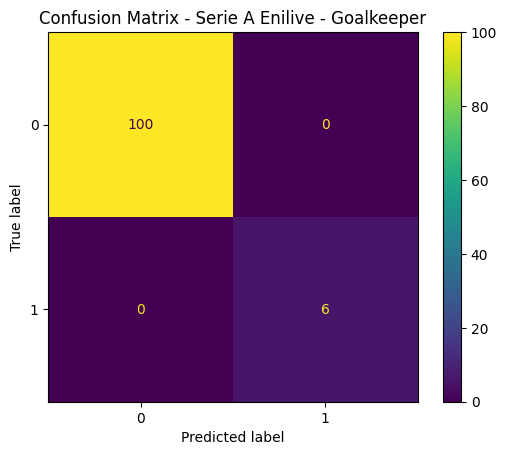

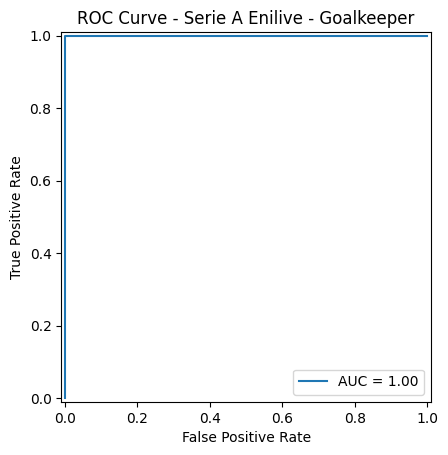


Evaluating league: Premier League

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.8301886792452831
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        69
           1       0.74      0.78      0.76        37

    accuracy                           0.83       106
   macro avg       0.81      0.82      0.82       106
weighted avg       0.83      0.83      0.83       106



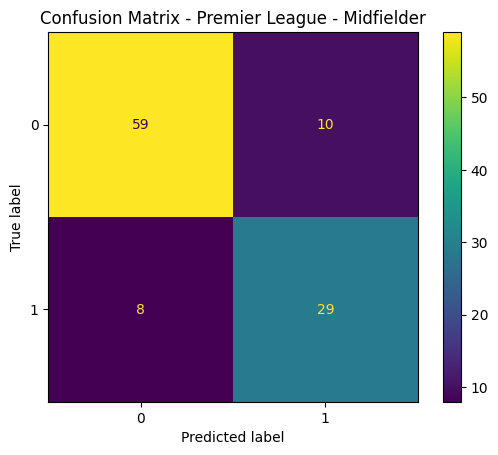

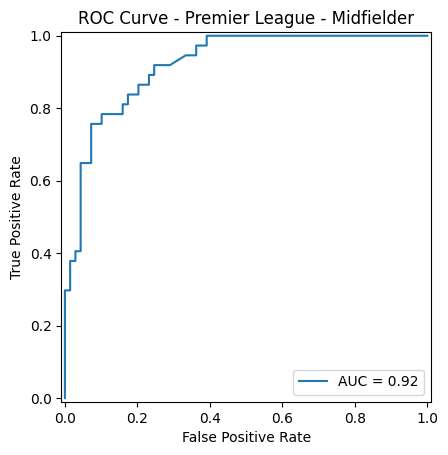


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.9716981132075472
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        66
           1       0.95      0.97      0.96        40

    accuracy                           0.97       106
   macro avg       0.97      0.97      0.97       106
weighted avg       0.97      0.97      0.97       106



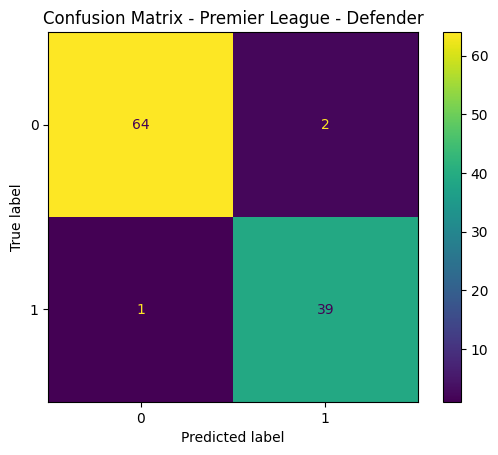

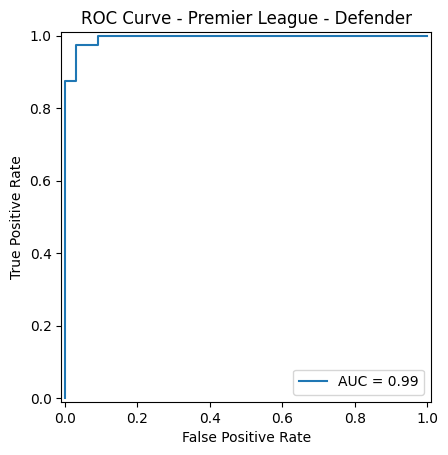


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.9245283018867925
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        88
           1       0.86      0.67      0.75        18

    accuracy                           0.92       106
   macro avg       0.90      0.82      0.85       106
weighted avg       0.92      0.92      0.92       106



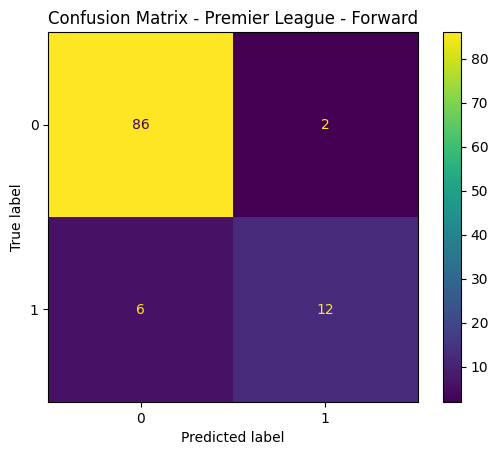

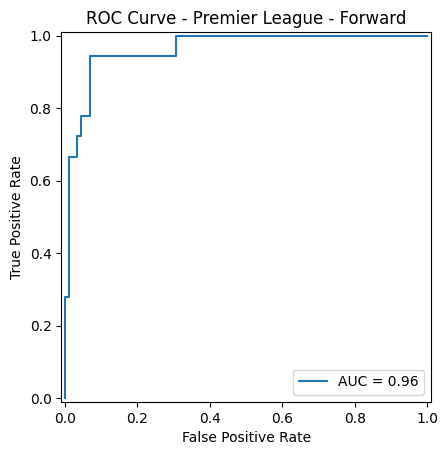


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00        11

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



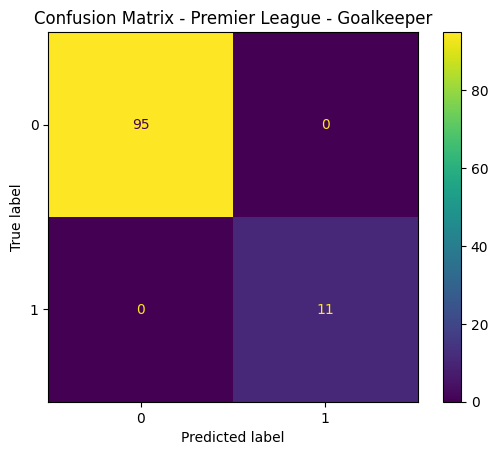

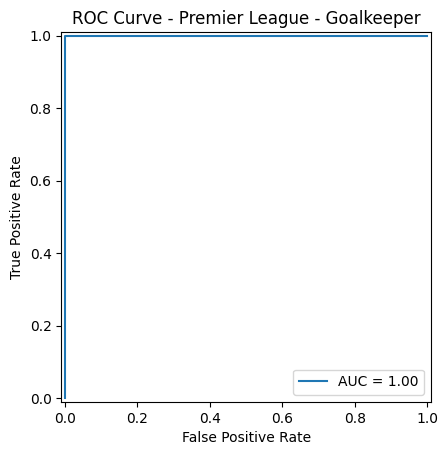


Evaluating league: Ligue 1 McDonald's

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.7567567567567568
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        45
           1       0.69      0.69      0.69        29

    accuracy                           0.76        74
   macro avg       0.74      0.74      0.74        74
weighted avg       0.76      0.76      0.76        74



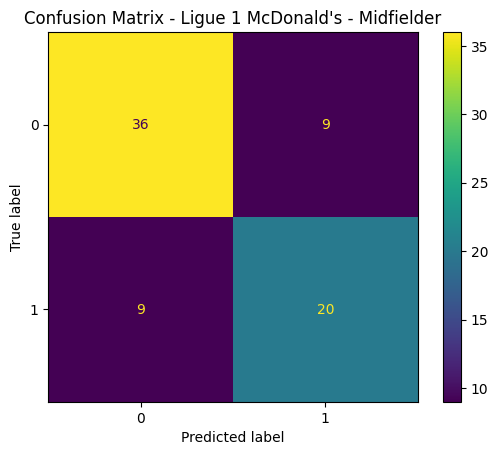

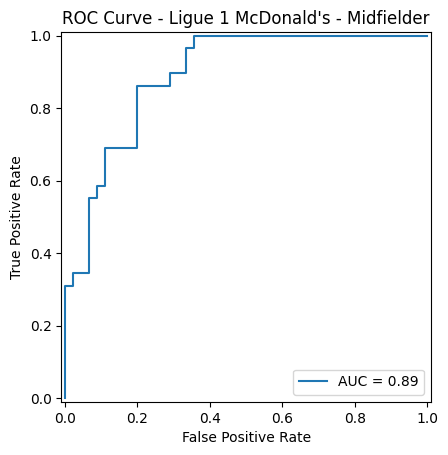


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.8918918918918919
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        47
           1       0.91      0.78      0.84        27

    accuracy                           0.89        74
   macro avg       0.90      0.87      0.88        74
weighted avg       0.89      0.89      0.89        74



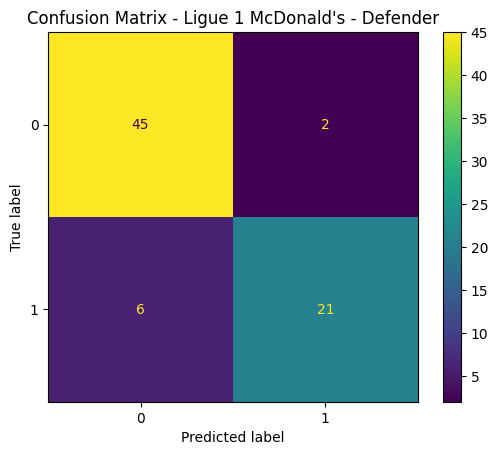

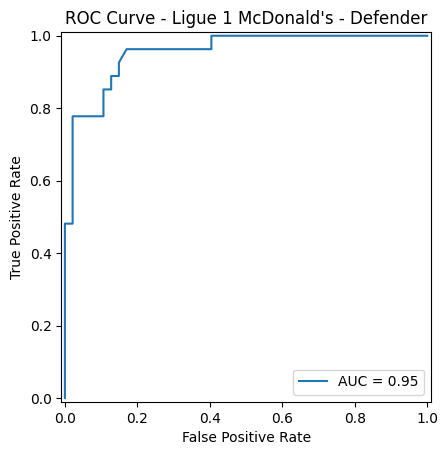


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.918918918918919
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        64
           1       0.75      0.60      0.67        10

    accuracy                           0.92        74
   macro avg       0.84      0.78      0.81        74
weighted avg       0.91      0.92      0.92        74



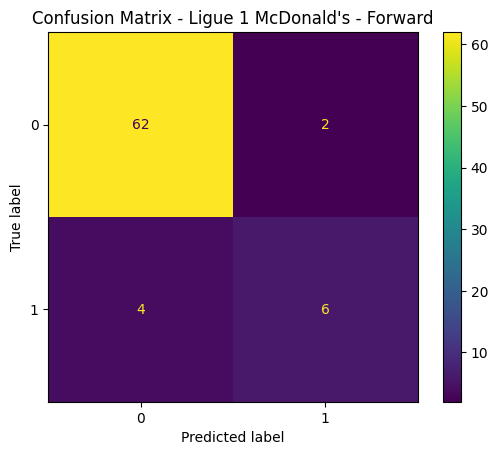

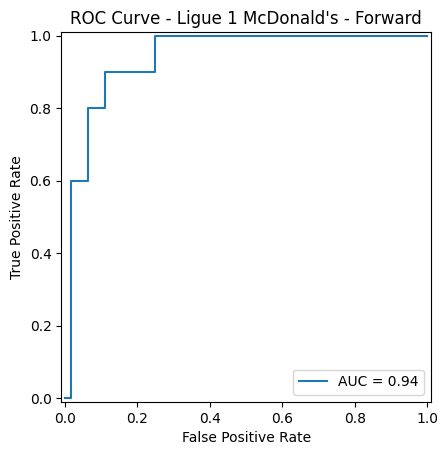


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00         8

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74



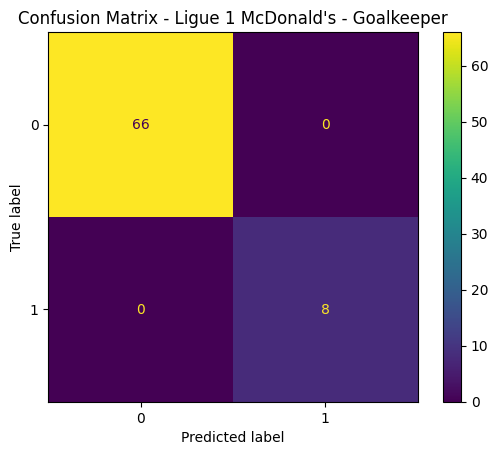

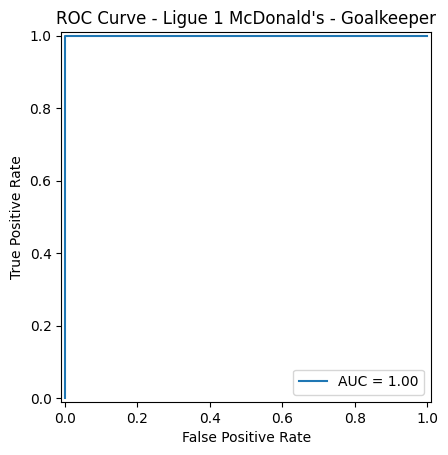


Evaluating league: LALIGA EA SPORTS

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.8090909090909091
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        66
           1       0.74      0.80      0.77        44

    accuracy                           0.81       110
   macro avg       0.80      0.81      0.80       110
weighted avg       0.81      0.81      0.81       110



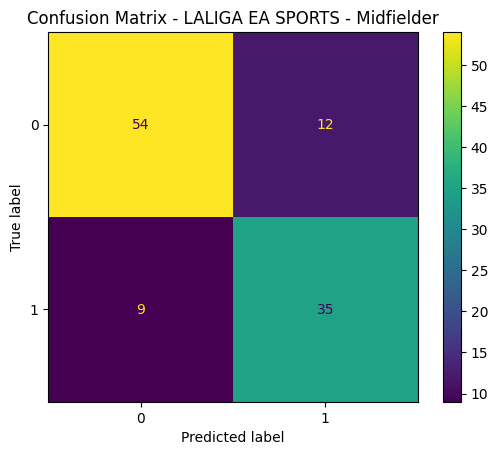

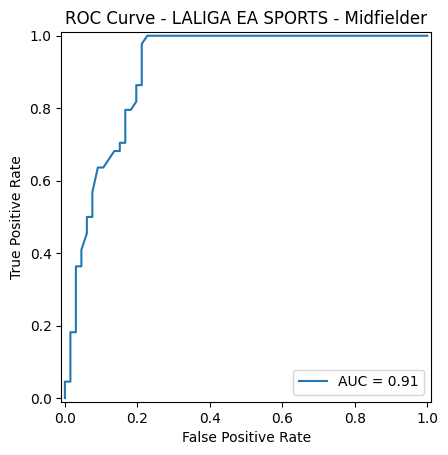


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        71
           1       0.89      0.87      0.88        39

    accuracy                           0.92       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.92      0.92      0.92       110



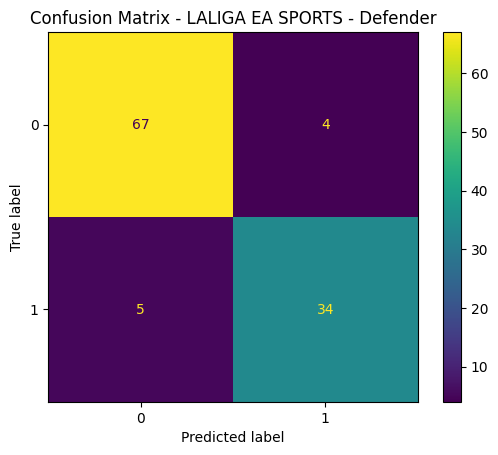

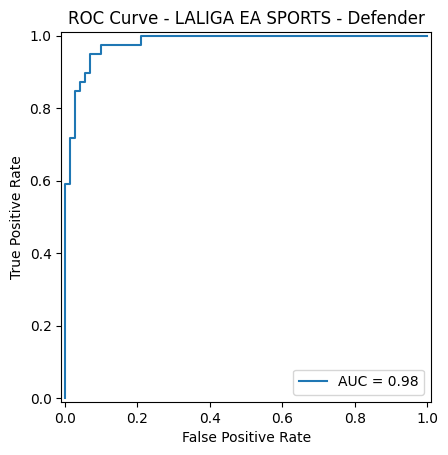


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.9636363636363636
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       1.00      0.73      0.85        15

    accuracy                           0.96       110
   macro avg       0.98      0.87      0.91       110
weighted avg       0.97      0.96      0.96       110



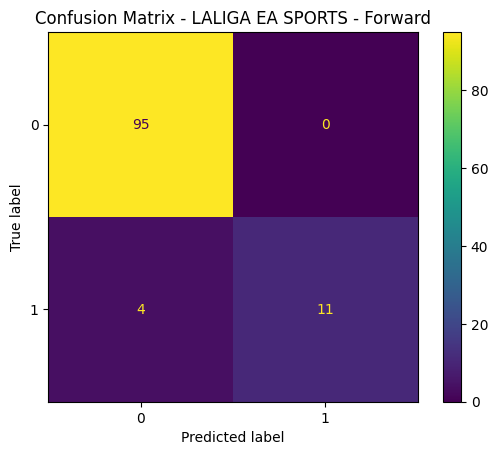

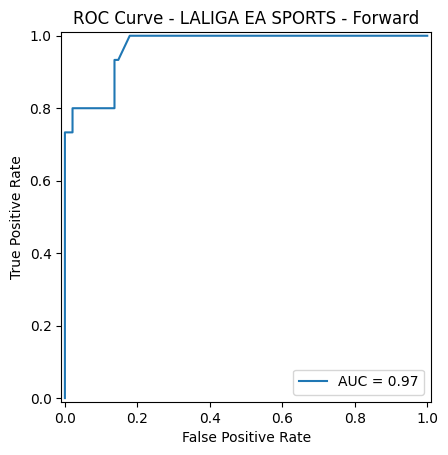


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00        12

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110



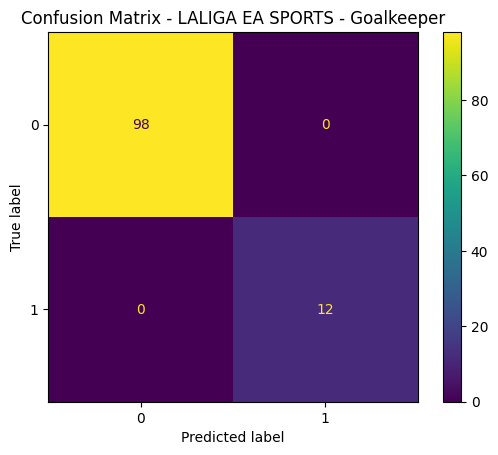

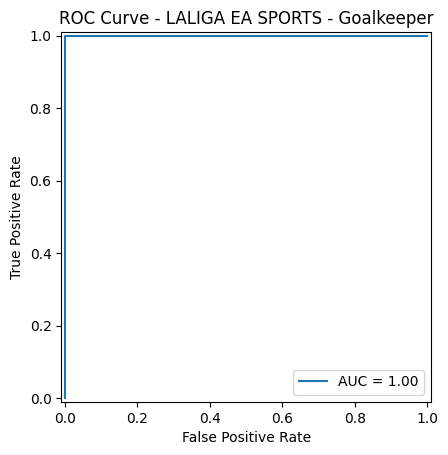


Evaluating league: Scottish Prem

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.7868852459016393
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        41
           1       0.67      0.70      0.68        20

    accuracy                           0.79        61
   macro avg       0.76      0.76      0.76        61
weighted avg       0.79      0.79      0.79        61



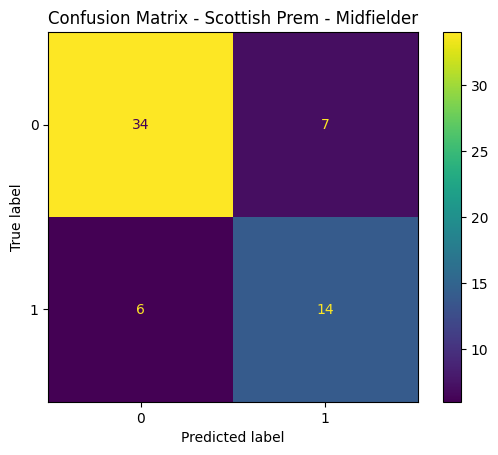

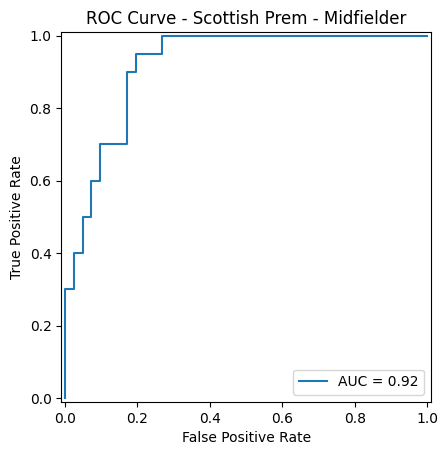


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.9672131147540983
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.95      0.95      0.95        21

    accuracy                           0.97        61
   macro avg       0.96      0.96      0.96        61
weighted avg       0.97      0.97      0.97        61



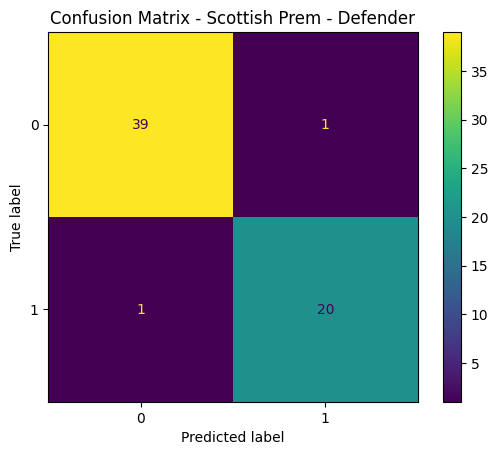

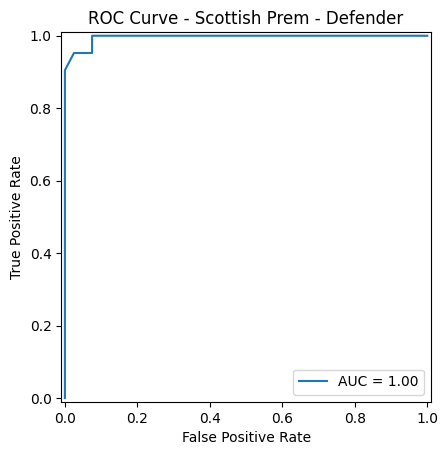


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.8360655737704918
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        50
           1       0.60      0.27      0.38        11

    accuracy                           0.84        61
   macro avg       0.73      0.62      0.64        61
weighted avg       0.81      0.84      0.81        61



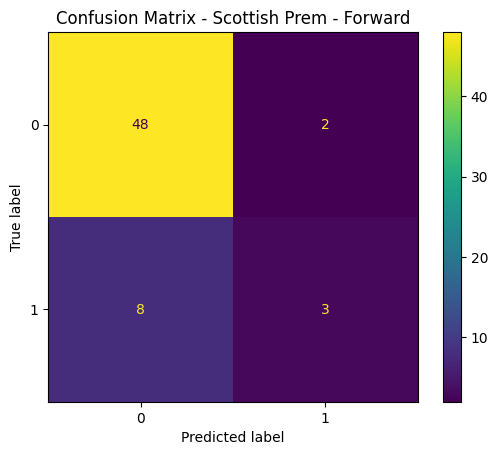

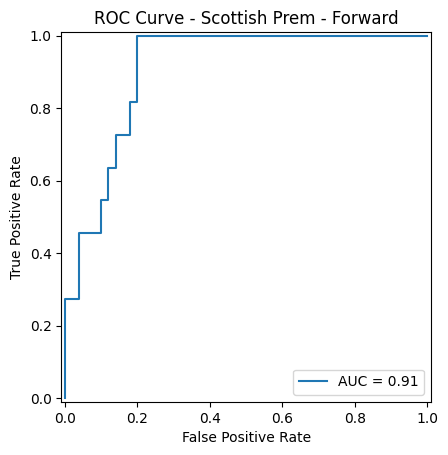


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00         9

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



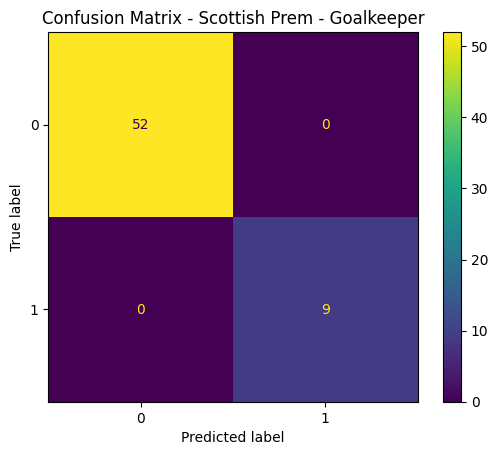

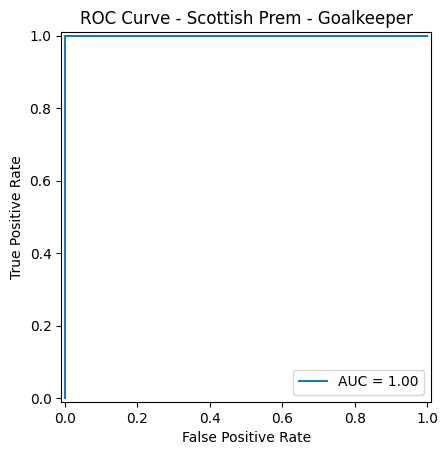


Evaluating league: Bundesliga

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.9074074074074074
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        60
           1       0.93      0.85      0.89        48

    accuracy                           0.91       108
   macro avg       0.91      0.90      0.91       108
weighted avg       0.91      0.91      0.91       108



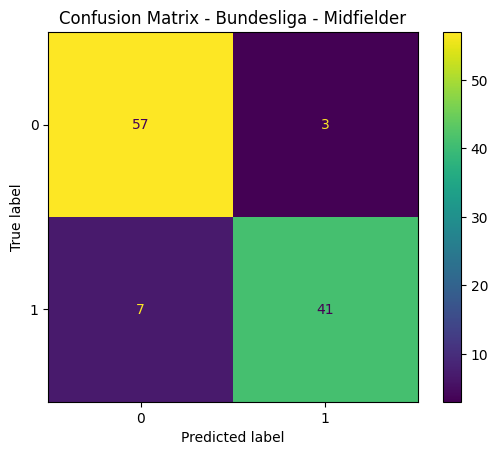

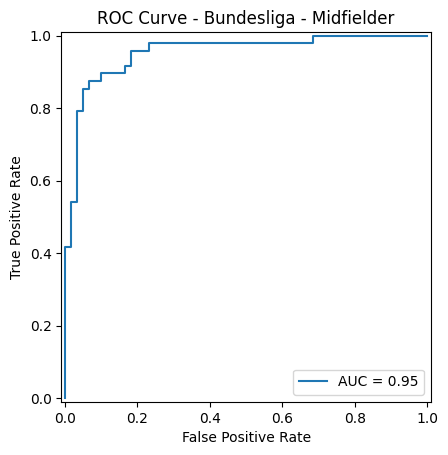


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.8703703703703703
              precision    recall  f1-score   support

           0       0.99      0.84      0.90        79
           1       0.68      0.97      0.80        29

    accuracy                           0.87       108
   macro avg       0.83      0.90      0.85       108
weighted avg       0.90      0.87      0.88       108



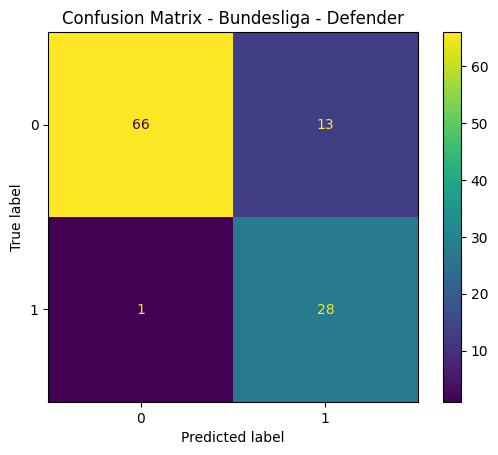

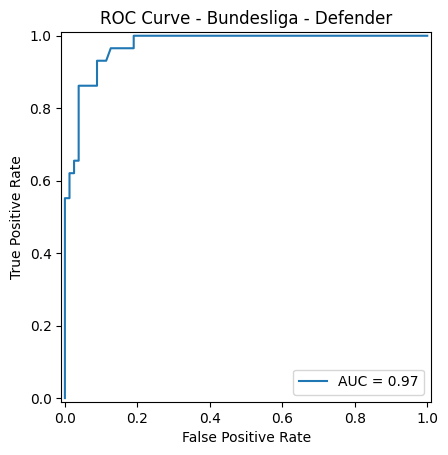


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.8981481481481481
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        90
           1       0.77      0.56      0.65        18

    accuracy                           0.90       108
   macro avg       0.84      0.76      0.79       108
weighted avg       0.89      0.90      0.89       108



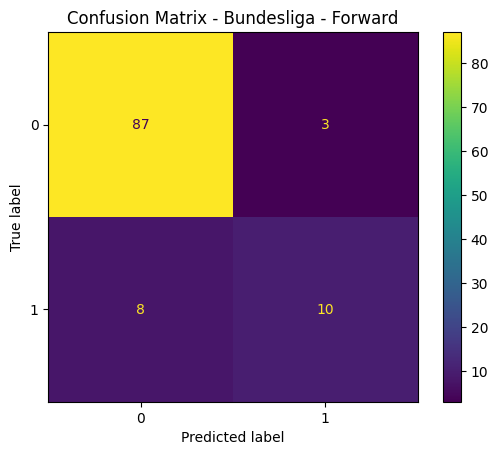

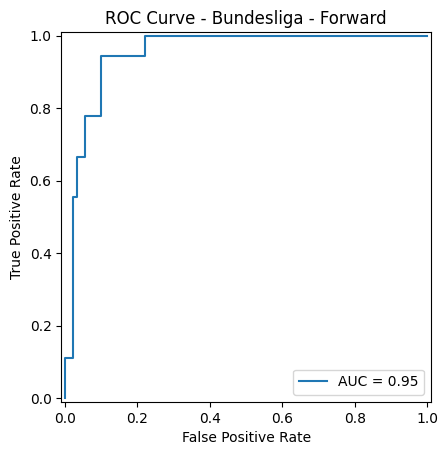


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00        13

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



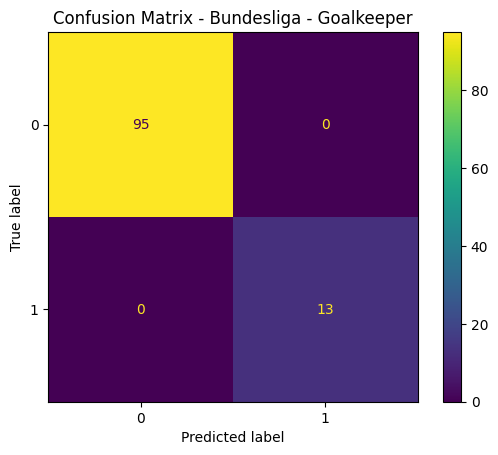

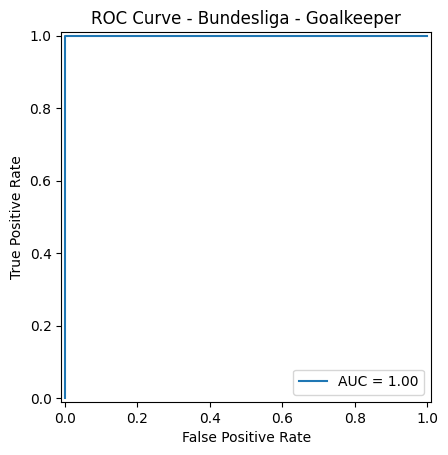


Evaluating league: Trendyol Süper Lig

Evaluating model for Midfielder...

Evaluation for Midfielder:
Accuracy: 0.7837837837837838
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        45
           1       0.71      0.76      0.73        29

    accuracy                           0.78        74
   macro avg       0.77      0.78      0.78        74
weighted avg       0.79      0.78      0.78        74



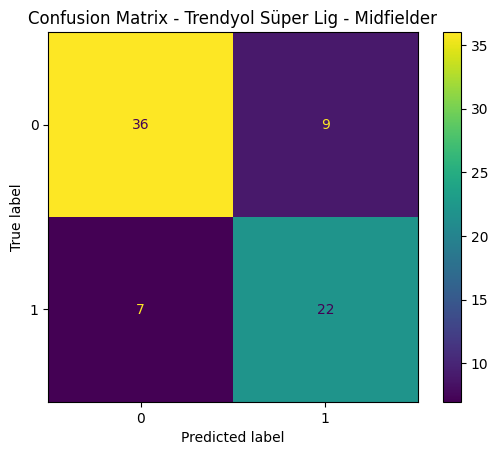

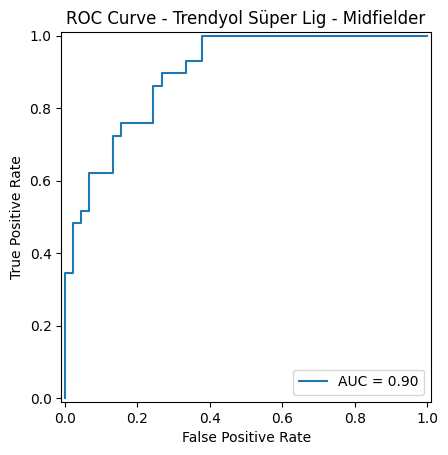


Evaluating model for Defender...

Evaluation for Defender:
Accuracy: 0.9054054054054054
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        48
           1       0.85      0.88      0.87        26

    accuracy                           0.91        74
   macro avg       0.89      0.90      0.90        74
weighted avg       0.91      0.91      0.91        74



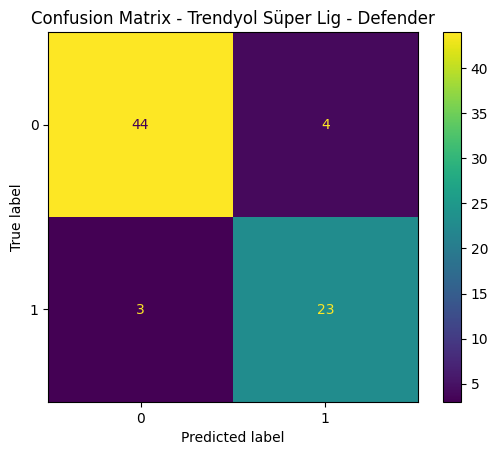

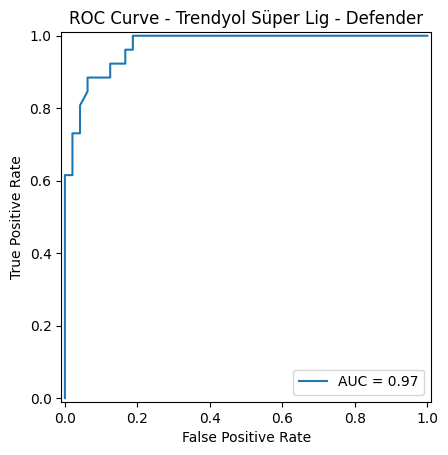


Evaluating model for Forward...

Evaluation for Forward:
Accuracy: 0.9324324324324325
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        65
           1       1.00      0.44      0.62         9

    accuracy                           0.93        74
   macro avg       0.96      0.72      0.79        74
weighted avg       0.94      0.93      0.92        74



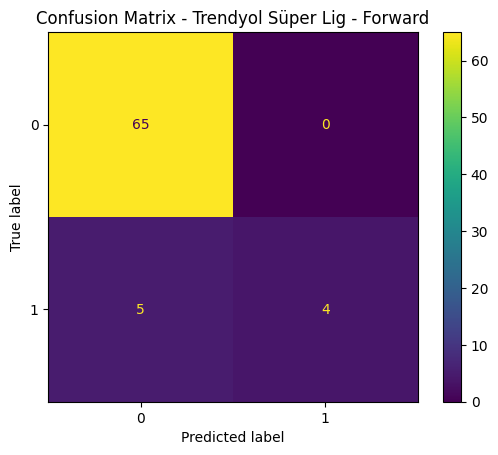

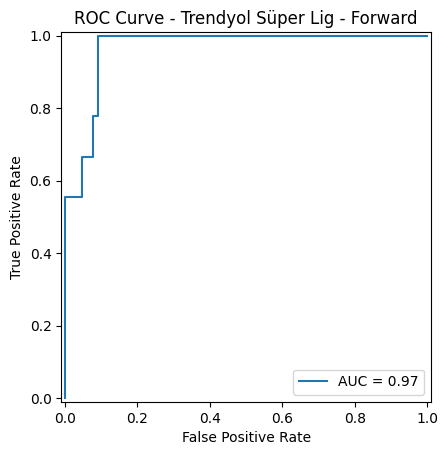


Evaluating model for Goalkeeper...

Evaluation for Goalkeeper:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        10

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74



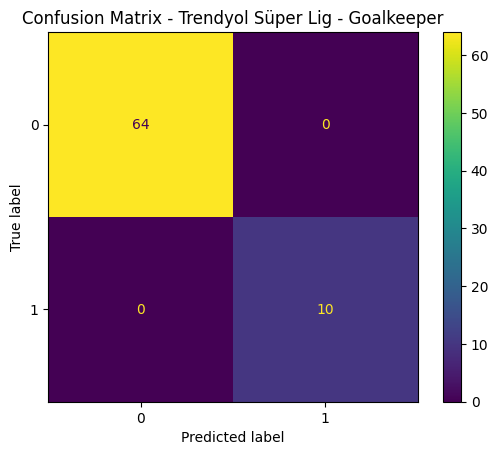

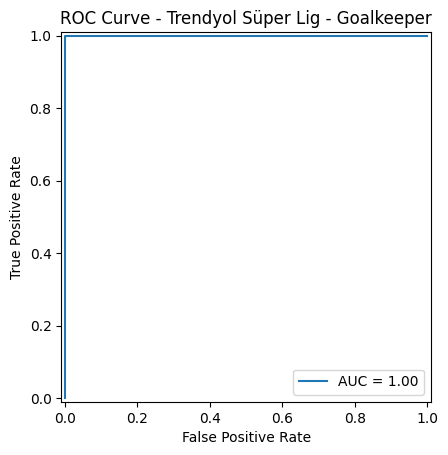

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

for league in leagues:
    print(f"\nEvaluating league: {league}")
    league_df_test = test_data[test_data['league'] == league]

    for pos in positions:
        print(f"\nEvaluating model for {pos}...")

        # Load the corresponding model
        model_filename = f'model_{league.replace(" ", "_")}_{pos.replace(" ", "_")}.pkl'
        with open(model_filename, 'rb') as file:
            model = pickle.load(file)

        # Select the features for this position
        if pos == 'Defender':
            selected_features = defender_attributes
        elif pos == 'Goalkeeper':
            selected_features = goalkeeper_attributes
        elif pos == 'Midfielder':
            selected_features = midfielder_attributes
        elif pos == 'Forward':
            selected_features = forward_attributes

        # Prepare test data
        X_test_full = league_df_test[selected_features]
        y_test_full = (league_df_test['position_category'] == pos).astype(int)

        # Make predictions
        y_pred = model.predict(X_test_full)
        y_proba = model.predict_proba(X_test_full)[:, 1]  # Needed for ROC

        # Evaluation
        print(f"\nEvaluation for {pos}:")
        print(f"Accuracy: {accuracy_score(y_test_full, y_pred)}")
        print(classification_report(y_test_full, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test_full, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix - {league} - {pos}")
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test_full, y_proba)
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.title(f"ROC Curve - {league} - {pos}")
        plt.show()



# **Discussions and Conclusions**
The models demonstrated strong performance on test data overall, but with notable variations across different leagues and positions. Goalkeeper classification was flawless across all leagues, achieving perfect 100% accuracy, precision and recall. This exceptional performance reflects the distinct set of attributes that differentiate goalkeepers from other positions, with skills like gk_diving and gk_positioning being clear discriminators. The consistency in goalkeeper classification suggests these models have perfectly learned the unique characteristics of this specialized position.

Defenders showed consistently high accuracy across most leagues, typically ranging between 88-97%. The Premier League and Scottish Premiership stood out with defender accuracy above 96%, indicating these models were particularly effective at identifying defensive players in these competitions. Precision and recall metrics for defenders were generally well-balanced, though some leagues like the Bundesliga showed slightly higher recall than precision, suggesting occasional over-prediction of defender labels. This high performance aligns with the clear defensive attributes (like sliding_tackle and interceptions) that make defenders relatively straightforward to classify.

Forward classification presented more variability, with accuracy ranging from 83.6% to 96.4% across leagues. While precision was often high, recall for the forward class was frequently lower, particularly in leagues like the Scottish Premiership where it dropped to just 0.27. This pattern suggests the models were conservative in labeling forwards, avoiding false positives at the cost of missing some true forwards. LaLiga's forward model was a notable exception, achieving both perfect precision and strong recall, possibly due to more distinct forward play characteristics in that league.

Midfielder classification showed the widest performance range, with accuracy varying from 75.7% in Ligue 1 to 90.7% in the Bundesliga. This substantial variation likely reflects differences in how midfield roles are defined and executed across leagues. The Bundesliga's strong midfield classification performance (90.7% accuracy) may indicate more clearly defined midfield attributes in German football, while challenges in Ligue 1 and Süper Lig (75-78% accuracy) suggest more overlapping traits between midfielders and other positions in these competitions.

# **References**

VanderPlas, J. (2016). *Python Data Science Handbook*. O'Reilly Media.  
GitHub repository: https://github.com/jakevdp/PythonDataScienceHandbook

OpenAI. (2023). *ChatGPT* (June 2023 version) [Large language model]. https://chat.openai.com  

DeepSeek. (2024). *DeepSeek-V3* [Large language model]. https://deepseek.com  